# Load Kinecal Data ELEC872 Project
### Leonard Moen | November 16th 2022

In [152]:
import pandas as pd
import numpy as np
import os
import importlib
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import label_binarize #Standardization and conversion of categorical labels to binary representation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, plot_roc_curve

import LoadKinecalFunctions
from LoadKinecalFunctions import *
importlib.reload(LoadKinecalFunctions)
from const import User, Exercise
import models
from models import *
importlib.reload(models)



<module 'models' from 'd:\\kinecal-1.0.1\\KINECAL-Balance-Assessment\\models.py'>

In [153]:
user = 0
excerciseList = [Exercise.QSECFS, Exercise.QSEOFS, Exercise.STS, Exercise.TS]

QSClosedDf = readKinecalFiles(excerciseList[0],user) 
QSOpenDf = readKinecalFiles(excerciseList[1],user) 
SemiTandemDf = readKinecalFiles(excerciseList[2],user) 
TandemDf = readKinecalFiles(excerciseList[3],user) 



### Seperate X and Y Dataframes

In [154]:
yDf = QSClosedDf.iloc[:,0:8]
yDf = yDf.drop(columns='movement')

QSClosedXDf =QSClosedDf.iloc[: ,9:-1]
QSOpenXDf =QSOpenDf.iloc[: ,9:-1]
SemiTandemXDf =SemiTandemDf.iloc[: ,9:-1]
TandemXDf =TandemDf.iloc[: ,9:-1]

### Replace Missing Data With Mean of That Class

In [155]:
QSClosedXDf = replaceMissingValues(QSClosedXDf,yDf)
QSOpenXDf = replaceMissingValues(QSOpenXDf,yDf)
SemiTandemXDf = replaceMissingValues(SemiTandemXDf,yDf)
TandemXDf = replaceMissingValues(TandemXDf,yDf)


[ 2 14 15]
[ 2 17 29 34 71]
[ 2 14 17 31 33 60 66]
[13 14 17 29 31 33 36 37 55 60 66 74 77]


### Perform Sample Normalization

In [156]:
#print(np.asarray(QS_Closed_x_df.iloc[0,:].values))
QSClosedXNormDf = datasetNormalization(QSClosedXDf)
QSOpenXNormDf = datasetNormalization(QSOpenXDf)
SemiTandemXNormDf = datasetNormalization(SemiTandemXDf)
TandemXNormDf = datasetNormalization(TandemXDf)

### Combine Excercises Into One Dataset

In [157]:
print(QSClosedXNormDf.shape,QSOpenXNormDf.shape,SemiTandemXNormDf.shape,TandemXNormDf.shape)
combinedXNormDf = pd.concat([QSClosedXNormDf,QSOpenXNormDf,SemiTandemXNormDf,TandemXDf],axis=1)
print(combinedXNormDf.shape)

(90, 16) (90, 16) (90, 16) (90, 16)
(90, 64)


### Seperate Into Training and Testing Sets

In [158]:
xTrain, xTest, yTrain, yTest = train_test_split(combinedXNormDf, yDf, test_size=0.2, random_state=42)

# labelTrain = label_binarize(yTrain.group, classes = ['HA','NF','FHs','FHm'])
# labelTest = label_binarize(yTest.group, classes = ['HA','NF','FHs','FHm'])
# print(labelTrain)
print(yTrain.group.values.shape)

(72,)


### Tune SVM

In [159]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-4, 1e-5, 'scale', 'auto'], 'C': [100, 250, 500, 750, 1000]},
                        {'kernel': ['sigmoid'], 'gamma': [1e-4, 1e-5, 'scale', 'auto'], 'C': [100, 250, 500, 750, 1000]}]
modelDir = './models/'
modelName = 'tunedSVM5Fold'
svmModel = tune_svm(xTrain,yTrain.group.values, tuned_parameters, 5, modelDir, modelName)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters: {'C': 250, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.5704761904761905


### Create Optimal SVM Model

In [173]:
#optimalParameters = [{'kernel': ['rbf'], 'gamma':['scale'],'C':[250]}]
#svc = train_svm(xTrain,yTrain.group.values.shape,optimalParameters,modelDir,modelName)

clf = svm.SVC(kernel = 'rbf' , C = 250, gamma='scale', probability=True)
clf.fit(xTrain, yTrain.group.values)

y_pred = clf.predict(xTest)


### Create Confusion Matrix and Classification Report

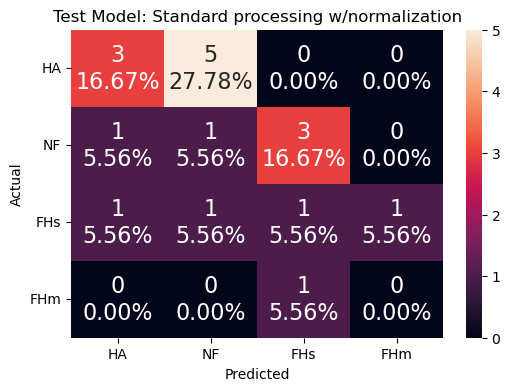

              precision    recall  f1-score   support

         FHm       0.00      0.00      0.00         1
         FHs       0.20      0.25      0.22         4
          HA       0.60      0.38      0.46         8
          NF       0.14      0.20      0.17         5

    accuracy                           0.28        18
   macro avg       0.24      0.21      0.21        18
weighted avg       0.35      0.28      0.30        18



In [174]:
classes = ['HA','NF','FHs','FHm']
cm_python = confusion_matrix(y_true=yTest.group.values, y_pred=y_pred, labels=classes)

plt.subplots(figsize=(6,4))

group_counts = ['{0:0.0f}'.format(value) for value in
                cm_python.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm_python.flatten()/np.sum(cm_python)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(4,4)
df_cm_python = pd.DataFrame(cm_python)

sns.heatmap(df_cm_python, annot=labels, fmt='',annot_kws={"size": 16}, xticklabels=classes, yticklabels=classes) # font size
plt.title('Test Model: Standard processing w/normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0)
plt.show()


print(classification_report(y_true=yTest.group.values, y_pred=y_pred))
